### Forecasting Mini-Course Sales
特徴量生成 + モデルの確認  
https://www.kaggle.com/code/gauthamupadhyaya/mini-course-sales

In [1]:
import numpy as np
import pandas as pd
import make_graph
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df_train = pd.read_csv("./data/train.csv", parse_dates=["date"])
df_test = pd.read_csv("./data/test.csv", parse_dates=["date"])
df_subm = pd.read_csv("./data/sample_submission.csv")

In [3]:
# make_graph.trends(df_train, "num_sold", 1200, 300, "graph0.html", "origin")

In [3]:
def datetime_features(df_temp):
    """
    Datetime feature üretir.
    """
    df_temp['month'] = df_temp['date'].dt.month
    df_temp['day'] = df_temp['date'].dt.day
    df_temp['year'] = df_temp['date'].dt.year
    df_temp['dayofyear'] = df_temp['date'].dt.day_of_year
    df_temp['dayofweek'] = df_temp['date'].dt.dayofweek
    df_temp['quarter'] = df_temp['date'].dt.quarter
    # df_temp['weekofyear'] = df_temp['date'].dt.weekofyear  # 見つからない
    df_temp['weekofyear'] = df_temp['date'].apply(lambda x: x.isocalendar()[1])
    df_temp['is_weekend'] = (df_temp['dayofweek'] >= 5).astype(np.int8)
    df_temp['is_month_start'] = df_temp.date.dt.is_month_start.astype(np.int8)
    df_temp['is_month_end'] = df_temp.date.dt.is_month_end.astype(np.int8)
    df_temp['monday'] = df_temp.date.dt.weekday.eq(0).astype(np.uint8)
    df_temp['tuesday'] = df_temp.date.dt.weekday.eq(1).astype(np.uint8)
    df_temp['wednesday'] = df_temp.date.dt.weekday.eq(2).astype(np.uint8)
    df_temp['thursday'] = df_temp.date.dt.weekday.eq(3).astype(np.uint8)
    df_temp['friday'] = df_temp.date.dt.weekday.eq(4).astype(np.uint8)
    df_temp['saturday'] = df_temp.date.dt.weekday.eq(5).astype(np.uint8)
    df_temp['sunday'] = df_temp.date.dt.weekday.eq(6).astype(np.uint8)
    df_temp['is_quarter_end'] = df_temp['date'].dt.is_quarter_end
    df_temp['is_quarter_start'] = df_temp['date'].dt.is_quarter_start
    df_temp['is_year_end'] = df_temp['date'].dt.is_year_end
    df_temp['is_year_start'] = df_temp['date'].dt.is_year_start
    
    return df_temp

df_train = datetime_features(df_train)
df_test = datetime_features(df_test)

In [4]:
def seasonality_features(df_temp):
    df_temp['month_sin'] = np.sin(2*np.pi*df_temp.month/12)
    df_temp['month_cos'] = np.cos(2*np.pi*df_temp.month/12)
    df_temp['day_sin'] = np.sin(2*np.pi*df_temp.day/24)    # 24 -> 30 -> 24
    df_temp['day_cos'] = np.cos(2*np.pi*df_temp.day/24)
    return df_temp

df_train = seasonality_features(df_train)
df_test = seasonality_features(df_test)
df_train.sample(5)

,id,date,country,store,product,num_sold,month,day,year,dayofyear,...,saturday,sunday,is_quarter_end,is_quarter_start,is_year_end,is_year_start,month_sin,month_cos,day_sin,day_cos
92314,92314,2020-05-15,Spain,Kaggle Learn,Using LLMs to Write Better,52,5,15,2020,136,...,0,0,False,False,False,False,5.000000e-01,-0.866025,-0.707107,-7.071068e-01
70243,70243,2019-07-26,Estonia,Kagglazon,Using LLMs to Win More Kaggle Competitions,254,7,26,2019,207,...,0,0,False,False,False,False,-5.000000e-01,-0.866025,0.500000,8.660254e-01
113237,113237,2021-02-18,Spain,Kaggle Learn,Using LLMs to Win Friends and Influence People,11,2,18,2021,49,...,0,0,False,False,False,False,8.660254e-01,0.500000,-1.000000,-1.836970e-16
25253,25253,2017-12-03,Japan,Kaggle Store,Using LLMs to Win More Kaggle Competitions,185,12,3,2017,337,...,0,1,False,False,False,False,-2.449294e-16,1.000000,0.707107,7.071068e-01
54494,54494,2018-12-28,Estonia,Kagglazon,Using LLMs to Write Better,423,12,28,2018,362,...,0,0,False,False,False,False,-2.449294e-16,1.000000,0.866025,5.000000e-01


In [8]:
# make_graph.trends(df_train, "day_sin", 1200, 300, "graph_tmp.html", "day_sin")
# make_graph.check_feature(df_train, "day_sin")

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
W, H, DPI = 10, 4, 100

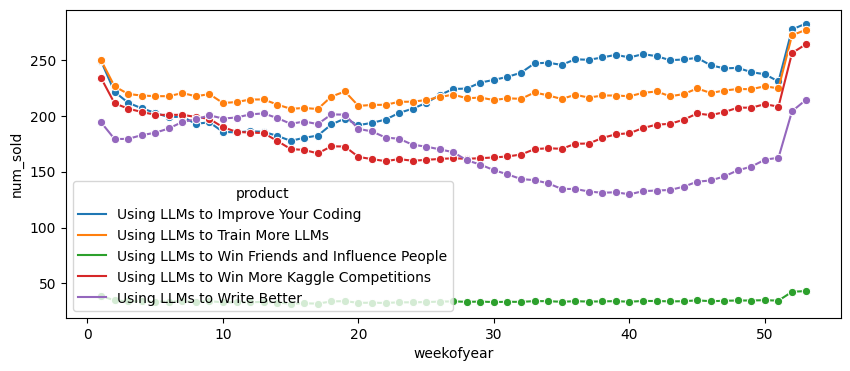

In [6]:
plt.figure(figsize=(W, H), dpi=DPI)
ax = sns.lineplot(data=df_train, x='weekofyear', y='num_sold', hue='product', errorbar=None, marker='o')

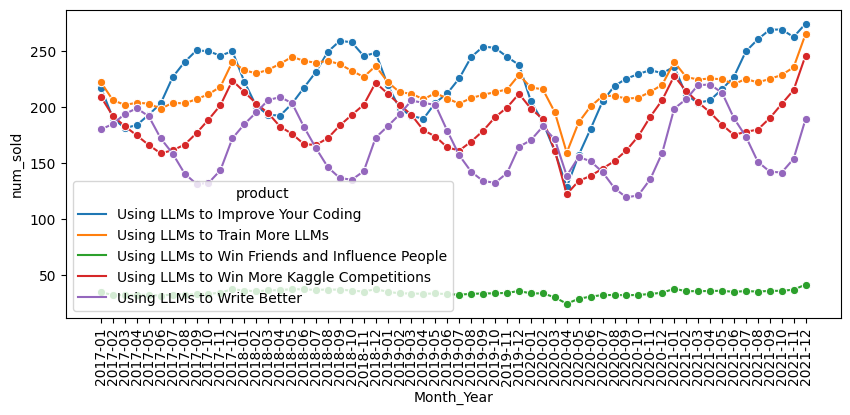

In [7]:
df_train['Month_Year'] = df_train['date'].dt.to_period('M').astype(str)
plt.figure(figsize=(W, H), dpi=DPI)
ax = sns.lineplot(data=df_train, x='Month_Year', y='num_sold', hue='product',  errorbar=None, estimator='mean', marker='o')
plt.xticks(rotation=90)
plt.show()

各モデルの性能確認

In [8]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [9]:
# new_train = df_train.drop(['id', 'date', 'Month_Year'], axis=1, inplace=False)
# 2020年抜く
new_train = df_train[df_train["year"]!=2020].drop(['id', 'date', 'Month_Year'], axis=1, inplace=False)

X = new_train.drop('num_sold', axis=1)
Y = new_train['num_sold']

minmax = MinMaxScaler()
Y_scaled = minmax.fit_transform(np.array(list(Y)).reshape(-1,1))

dummied_train = pd.get_dummies(X)
X_train = dummied_train[dummied_train.year.isin([2017, 2018, 2019, 2020])]
Y_train = Y_scaled[:len(X_train)]
X_test = dummied_train[dummied_train.year == 2021]
Y_test = Y_scaled[len(X_train):]

In [10]:
X_train.drop('year', axis=1, inplace=True)
X_test.drop('year', axis=1, inplace=True)
X_train.head()

/tmp/ipykernel_7637/859943693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop('year', axis=1, inplace=True)
/tmp/ipykernel_7637/859943693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('year', axis=1, inplace=True)


,month,day,dayofyear,dayofweek,quarter,weekofyear,is_weekend,is_month_start,is_month_end,monday,...,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,True,False,False,False,False
1,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,True,False,False,False
2,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,False,True,False,False
3,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,False,False,True,False
4,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,False,False,False,True


In [11]:
Y_test

array([[0.02469136],
       [0.02469136],
       [0.00145243],
       ...,
       [0.07843137],
       [0.46332607],
       [0.389252  ]])

In [12]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import time

In [27]:
regressors = [LinearRegression(), 
              Lasso(), 
              DecisionTreeRegressor(), 
              Ridge(), 
              ElasticNet(), 
              RandomForestRegressor(), 
              XGBRegressor(), 
              CatBoostRegressor(), 
              LGBMRegressor(), 
              GradientBoostingRegressor(), 
              HistGradientBoostingRegressor()]

scores = []
for model in regressors:
    start = time.time()
    model.fit(X_train, Y_train)
    train_time = time.time() - start
    start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time()-start
    print(f"{str(model)[:-2]}, {train_time:.3f}s")
    # print(str(model)[:-2])
    # print("\tTraining time: %0.3fs" % train_time)
    # print("\tPrediction time: %0.3fs" % predict_time)
    # print("\tExplained variance:", explained_variance_score(Y_test, y_pred))
    # print("\tMean absolute error:", mean_absolute_error(Y_test, y_pred))
    # print("\tR2 score:", r2_score(Y_test, y_pred))
    # print()
    scores.append([str(model)[:-2], train_time, explained_variance_score(Y_test, y_pred),
                   mean_squared_error(Y_test, y_pred, squared=False), mean_absolute_error(Y_test, y_pred),
                   r2_score(Y_test, y_pred)])
df_score = pd.DataFrame(scores, columns=["model", "train_time", "explained_variance", "mae", "rmse", "r2"])

LinearRegression, 0.079s
Lasso, 0.098s
DecisionTreeRegressor, 0.557s
Ridge, 0.019s
ElasticNet, 0.090s


/home/shin/.local/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor, 34.489s
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, .., 1.716s
Learning rate set to 0.082161
0:	learn: 0.1229162	total: 4.17ms	remaining: 4.17s
1:	learn: 0.1137875	total: 7.67ms	remaining: 3.83s
2:	learn: 0.1053895	total: 11ms	remaining: 3.65s
3:	learn: 0.0977586	total: 14.4ms	remaini

/home/shin/.local/lib/python3.8/site-packages/lightgbm/basic.py:295: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/home/shin/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor, 6.172s


/home/shin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor, 0.577s


In [28]:
df_score.sort_values("rmse")

,model,train_time,explained_variance,mae,rmse,r2
8,LGBMRegressor,0.172506,9.737823e-01,0.024815,0.013896,0.970378
10,HistGradientBoostingRegressor,0.576940,9.737182e-01,0.024859,0.013911,0.970273
7,<catboost.core.CatBoostRegressor object at 0x7...,3.498442,9.744728e-01,0.024613,0.013999,0.970859
6,"XGBRegressor(base_score=None, booster=None, ca...",1.716394,9.724210e-01,0.025641,0.014659,0.968372
5,RandomForestRegressor,34.488641,9.712540e-01,0.026073,0.014908,0.967299
9,GradientBoostingRegressor,6.172054,9.601957e-01,0.029984,0.017319,0.956752
2,DecisionTreeRegressor,0.557120,9.598929e-01,0.030571,0.017667,0.955041
3,Ridge,0.018982,7.506053e-01,0.072498,0.049644,0.747158
0,LinearRegression,0.079071,7.506117e-01,0.072497,0.049645,0.747165
1,Lasso,0.097987,2.220446e-16,0.144427,0.103388,-0.003439


In [13]:
from sklearn.metrics import mean_squared_error
lgbm = LGBMRegressor(boosting_type='goss', max_depth=15, n_estimators = 150)
lgbm.fit(X_train, Y_train)
test_pred = lgbm.predict(X_test)

print("\nTest Scores")
print("\tExplained variance:", explained_variance_score(Y_test, test_pred))
print("\tMean absolute error:", mean_absolute_error(Y_test, test_pred))
print("\tMean squared error:", mean_squared_error(Y_test, test_pred))
print("\tR2 score:", r2_score(Y_test, test_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

/home/shin/.local/lib/python3.8/site-packages/lightgbm/basic.py:295: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.

Test Scores
	Explained variance: 0.9742520097520059
	Mean absolute error: 0.013829718805402704
	Mean squared error: 0.0006082663191582819
	R2 score: 0.970739056766398


In [28]:
X_train

,month,day,dayofyear,dayofweek,quarter,weekofyear,is_weekend,is_month_start,is_month_end,monday,...,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,True,False,False,False,False
1,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,True,False,False,False
2,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,False,True,False,False
3,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,False,False,True,False
4,1,1,1,6,1,52,1,1,0,0,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82120,12,31,365,1,4,1,0,0,1,0,...,False,True,True,False,False,True,False,False,False,False
82121,12,31,365,1,4,1,0,0,1,0,...,False,True,True,False,False,False,True,False,False,False
82122,12,31,365,1,4,1,0,0,1,0,...,False,True,True,False,False,False,False,True,False,False
82123,12,31,365,1,4,1,0,0,1,0,...,False,True,True,False,False,False,False,False,True,False


In [26]:
X_test.columns

Index(['month', 'day', 'dayofyear', 'dayofweek', 'quarter', 'weekofyear',
       'is_weekend', 'is_month_start', 'is_month_end', 'monday', 'tuesday',
       'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
       'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'country_Argentina',
       'country_Canada', 'country_Estonia', 'country_Japan', 'country_Spain',
       'store_Kagglazon', 'store_Kaggle Learn', 'store_Kaggle Store',
       'product_Using LLMs to Improve Your Coding',
       'product_Using LLMs to Train More LLMs',
       'product_Using LLMs to Win Friends and Influence People',
       'product_Using LLMs to Win More Kaggle Competitions',
       'product_Using LLMs to Write Better'],
      dtype='object')

In [30]:
def get_predict(df, model, feat_columns):
    """予測結果取得"""
    df_dummies = pd.get_dummies(df[feat_columns])
    pred = model.predict(df_dummies)
    rescaled_preds = minmax.inverse_transform(np.array(pred).reshape(-1,1))
    return list(rescaled_preds.reshape(len(rescaled_preds)).astype(int))

In [32]:
get_predict(df_train, lgbm, X_train.columns)

KeyError: "['country_Argentina', 'country_Canada', 'country_Estonia', 'country_Japan', 'country_Spain', 'store_Kagglazon', 'store_Kaggle Learn', 'store_Kaggle Store', 'product_Using LLMs to Improve Your Coding', 'product_Using LLMs to Train More LLMs', 'product_Using LLMs to Win Friends and Influence People', 'product_Using LLMs to Win More Kaggle Competitions', 'product_Using LLMs to Write Better'] not in index"

In [14]:
new_test = pd.get_dummies(df_test.drop(['id', 'year', 'date'], axis=1))
test_predict = lgbm.predict(new_test)
rescaled_preds = minmax.inverse_transform(np.array(test_predict).reshape(-1,1))
rescaled_preds = list(rescaled_preds.reshape(len(rescaled_preds)).astype(int))
df_test['num_sold'] = rescaled_preds
df_test.sample(5)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


,id,date,country,store,product,month,day,year,dayofyear,dayofweek,...,sunday,is_quarter_end,is_quarter_start,is_year_end,is_year_start,month_sin,month_cos,day_sin,day_cos,num_sold
21559,158509,2022-10-15,Estonia,Kaggle Learn,Using LLMs to Write Better,10,15,2022,288,5,...,0,False,False,False,False,-0.866025,0.500000,-0.707107,-0.707107,37
22034,158984,2022-10-21,Japan,Kagglazon,Using LLMs to Write Better,10,21,2022,294,4,...,0,False,False,False,False,-0.866025,0.500000,-0.707107,0.707107,384
9454,146404,2022-05-07,Argentina,Kaggle Learn,Using LLMs to Write Better,5,7,2022,127,5,...,0,False,False,False,False,0.500000,-0.866025,0.965926,-0.258819,34
1006,137956,2022-01-14,Estonia,Kaggle Learn,Using LLMs to Train More LLMs,1,14,2022,14,4,...,0,False,False,False,False,0.500000,0.866025,-0.500000,-0.866025,60
22182,159132,2022-10-23,Japan,Kagglazon,Using LLMs to Win Friends and Influence People,10,23,2022,296,6,...,1,False,False,False,False,-0.866025,0.500000,-0.258819,0.965926,105


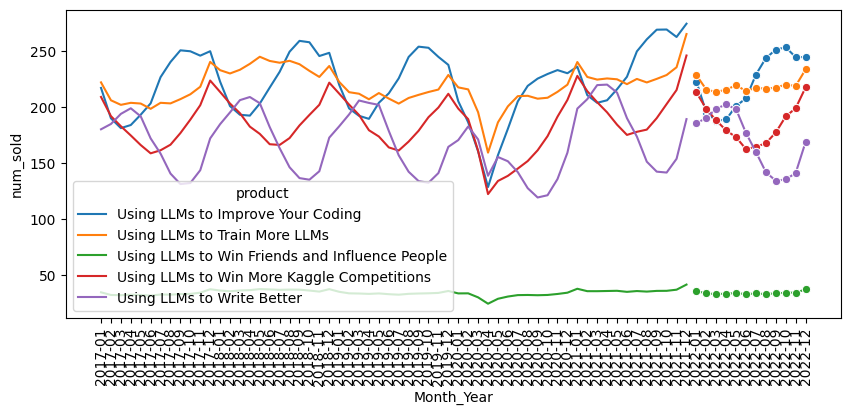

In [15]:
df_test['Month_Year'] = df_test['date'].dt.to_period('M').astype(str)
plt.figure(figsize=(W, H), dpi=DPI)
ax = sns.lineplot(data=df_train, x='Month_Year', y='num_sold', hue='product',  errorbar=None, estimator='mean')
ax = sns.lineplot(data=df_test, x='Month_Year', y='num_sold', hue='product',  errorbar=None, estimator='mean', marker='o', legend=None)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_train

In [21]:
df_test.head(1)

,id,date,country,store,product,month,day,year,dayofyear,dayofweek,...,is_quarter_end,is_quarter_start,is_year_end,is_year_start,month_sin,month_cos,day_sin,day_cos,num_sold,Month_Year
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,1,1,2022,1,5,...,False,True,False,True,0.5,0.866025,0.258819,0.965926,56,2022-01


In [16]:
print(df_test.shape, df_subm.shape)

(27375, 32) (27375, 2)


In [17]:
df_subm = pd.merge(df_subm.drop(columns=["num_sold"]), df_test[["id", "num_sold"]].copy(), how="left")
df_subm["num_sold"].isna().sum()

0

In [18]:
df_subm

,id,num_sold
0,136950,56
1,136951,55
2,136952,10
3,136953,54
4,136954,40
...,...,...
27370,164320,747
27371,164321,729
27372,164322,102
27373,164323,709


In [19]:
df_subm.to_csv("./submission.csv", index=False)

`Public score: 53.35321` あれ？最初の2020年抜いて平均(51.23264)より悪い  
`Public score: 52.75649` 2020年抜いてみたけど、ちょっと良くなっただけ  